# Problem Statement

The Iowa State Legislature is currently considering an adjusment to the liquor tax rates in the state, and will base their decision on an analysis of liquor sales over the past year, and projected sales for 2016.

We need to use existing data from 2015 and 2016 in order to determine if sales already made in Quarter 1 of 2016 can predict the total sales for all of 2016. 

We also need to analyze the results in the context of liquor sold by stores according to their county and city. 

Finally, as a result of our analysis, we need to lend any insight about the potential impact of an adjustment in the state liquor tax rates for stores in various counties and cities.

# Data

We will use a 10% sample of liquor sales in Iowa from the beginning of 2015 to date. This data set tracks the individual sales for each store that holds a Class E liquor license, which grants stores the ability to sell sealed bottles for off-premises consumption. These stores are also allowed to obtain a separate permit for wholesale distribution to businesses that can only sell for on-premises consumption, like bars or restaurants.

In [50]:
import pandas as pd
import datetime
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from IPython.display import Image

In [51]:
def read_csv(path): return pd.read_csv( path, sep = ',' ) 

path = "../../01-projects/assets/03-project3-assets/Iowa_Liquor_sales_sample.csv" # relative path
df = read_csv(path)

In [52]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,02/11/2016,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,02/03/2016,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,08/18/2015,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


In [53]:
df.dtypes

Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object

In [54]:
df.count()

Date                     270955
Store Number             270955
City                     270955
Zip Code                 270955
County Number            269878
County                   269878
Category                 270887
Category Name            270323
Vendor Number            270955
Item Number              270955
Item Description         270955
Bottle Volume (ml)       270955
State Bottle Cost        270955
State Bottle Retail      270955
Bottles Sold             270955
Sale (Dollars)           270955
Volume Sold (Liters)     270955
Volume Sold (Gallons)    270955
dtype: int64

In [55]:
df.shape

(270955, 18)

In [56]:
#Remove 'volume sold(gallons)' since it's really the same information as 'volume sold(liters)'
#Keep liters since other columns are measured in liters as well
del df['Volume Sold (Gallons)']

In [57]:
# Remove $ from certain columns
df['State Bottle Cost'] = [x.lstrip('$')for x in df['State Bottle Cost']]
df['State Bottle Retail'] = [x.lstrip('$')for x in df['State Bottle Retail']]
df['Sale (Dollars)'] = [x.lstrip('$')for x in df['Sale (Dollars)']]

#Convert dates
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

# Convert integers
df[['State Bottle Cost','State Bottle Retail', 'Sale (Dollars)']] = df[['State Bottle Cost','State Bottle Retail', 
                                                                        'Sale (Dollars)']].astype(float)

# Add Margin column and Price per liter column
df['Margin'] = df['State Bottle Retail'] - df['State Bottle Cost']
df['Price per Liter'] = (df['State Bottle Retail'] / df['Bottle Volume (ml)'])*1000

In [58]:
# Sales per store, 2015. Only includes stores that were open for all of 2015.

# Filter by our start and end dates
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales2015 = df[mask]

# Group by store name
sales2015 = sales2015.groupby(by=["Store Number"], as_index=False)
# Compute sums, means
sales2015 = sales2015.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})
# Collapse the column indices
sales2015.columns = [' '.join(col).strip() for col in sales2015.columns.values]

In [59]:
#Same thing as above, except make dataframe that only consists of sales from 2015 Q1
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date2 = pd.Timestamp("20150101")
end_date2 = pd.Timestamp("20150331")
mask2 = (df['Date'] >= start_date2) & (df['Date'] <= end_date2)
sales2015Q1 = df[mask2]

sales2015Q1 = sales2015Q1.groupby(by=["Store Number"], as_index=False)

sales2015Q1 = sales2015Q1.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

sales2015Q1.columns = [' '.join(col).strip() for col in sales2015Q1.columns.values]

In [60]:
#Drop overlapping columns from this dataframe to enable merge with 2015 sales
sales2015Q1.drop(['City <lambda>','County Number <lambda>', 'Price per Liter mean', 'Zip Code <lambda>',
                 'Volume Sold (Liters) sum', 'Volume Sold (Liters) mean', 'Margin mean'], axis=1, inplace=True)

sales2015Q1.columns = [u'Store Number', u'Q1 Total Sales', u'Q1 Average Sales']
sales2015Q1.shape

(1262, 3)

In [61]:
#Merge, so now each store will have 2015 sales and corresponding Q1 sales
sales15 = pd.merge(sales2015, sales2015Q1, on='Store Number', how='outer')

In [62]:
# Repeat process, except for 2016. We'll need this to run our prediction later

# Filter by our start and end dates
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date3 = pd.Timestamp("20160101")
end_date3 = pd.Timestamp("20161231")
mask3 = (df['Date'] >= start_date3) & (df['Date'] <= end_date3)
sales2016 = df[mask3]

# Group by store name
sales2016 = sales2016.groupby(by=["Store Number"], as_index=False)
# Compute sums, means
sales2016 = sales2016.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})
# Collapse the column indices
sales2016.columns = [' '.join(col).strip() for col in sales2016.columns.values]

In [63]:
#Same thing, just Q1 for 2016
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date4 = pd.Timestamp("20160101")
end_date4 = pd.Timestamp("20160331")
mask4 = (df['Date'] >= start_date4) & (df['Date'] <= end_date4)
sales2016Q1 = df[mask4]

sales2016Q1 = sales2016Q1.groupby(by=["Store Number"], as_index=False)

sales2016Q1 = sales2016Q1.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], # just extract once, should be the same
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

sales2016Q1.columns = [' '.join(col).strip() for col in sales2016Q1.columns.values]

In [64]:
#Drop columns from 2016 Q1

sales2016Q1.drop(['City <lambda>','County Number <lambda>', 'Price per Liter mean', 'Zip Code <lambda>',
                 'Volume Sold (Liters) sum', 'Volume Sold (Liters) mean', 'Margin mean'], axis=1, inplace=True)

sales2016Q1.columns = [u'Store Number', u'Q1 Total Sales', u'Q1 Average Sales']
sales2016Q1.shape

(1309, 3)

In [65]:
sales16 = pd.merge(sales2016, sales2016Q1, on='Store Number', how='outer')

In [66]:
#uniform column names in the 2015 and 2016 dataframes
sales15.columns = [u'storeNumber', u'city', u'totalSalesDollars', u'avgSalesDollars', u'countyNumber',
                  u'avgPrice(L)', u'zipCode', u'totalVolSold(L)', u'avgVolSold(L)', u'avgMargin', u'totalSalesQ1',
                  u'avgSalesQ1']

In [67]:
sales16.columns = [u'storeNumber', u'city', u'totalSalesDollars', u'avgSalesDollars', u'countyNumber',
                  u'avgPrice(L)16', u'zipCode', u'totalVolSold(L)16', u'avgVolSold(L)16', u'avgMargin', u'totalSalesQ1',
                  u'avgSalesQ1']

In [68]:
sales15.dropna(inplace=True)
sales15.head()

,storeNumber,city,totalSalesDollars,avgSalesDollars,countyNumber,avgPrice(L),zipCode,totalVolSold(L),avgVolSold(L),avgMargin,totalSalesQ1,avgSalesQ1
0,2106,CEDAR FALLS,146326.22,277.658861,7.0,17.856601,50613,9731.85,18.466509,5.166319,39287.29,304.552636
1,2113,GOWRIE,9310.22,63.334830,94.0,18.504292,50543,659.85,4.488776,5.445102,2833.25,67.458333
2,2130,WATERLOO,111871.43,285.386301,7.0,16.835669,50703,6891.37,17.580026,4.925842,24272.57,278.995057
3,2152,ROCKWELL,7721.08,54.759433,17.0,13.020983,50469,633.37,4.491986,4.322624,2003.46,62.608125
4,2178,WAUKON,24324.18,102.633671,3.0,16.062136,52172,1917.12,8.089114,4.868861,5856.41,122.008542


In [69]:
sales15.dtypes

storeNumber            int64
city                  object
totalSalesDollars    float64
avgSalesDollars      float64
countyNumber         float64
avgPrice(L)          float64
zipCode               object
totalVolSold(L)      float64
avgVolSold(L)        float64
avgMargin            float64
totalSalesQ1         float64
avgSalesQ1           float64
dtype: object

In [70]:
sales15.count()

storeNumber          1261
city                 1261
totalSalesDollars    1261
avgSalesDollars      1261
countyNumber         1261
avgPrice(L)          1261
zipCode              1261
totalVolSold(L)      1261
avgVolSold(L)        1261
avgMargin            1261
totalSalesQ1         1261
avgSalesQ1           1261
dtype: int64

In [71]:
sales15.shape

(1261, 12)

In [72]:
sales16.dropna(inplace=True)
sales16.head()

,storeNumber,city,totalSalesDollars,avgSalesDollars,countyNumber,avgPrice(L)16,zipCode,totalVolSold(L)16,avgVolSold(L)16,avgMargin,totalSalesQ1,avgSalesQ1
0,2106,CEDAR FALLS,30523.75,240.344488,7.0,18.064496,50613,2117.75,16.675197,5.214646,30523.75,240.344488
1,2113,GOWRIE,2065.90,55.835135,94.0,17.483024,50543,177.00,4.783784,5.367838,2065.90,55.835135
2,2130,WATERLOO,27856.11,238.086410,7.0,17.452157,50703,1556.90,13.306838,5.312222,27856.11,238.086410
3,2152,ROCKWELL,1376.43,45.881000,17.0,12.525492,50469,140.13,4.671000,4.252000,1376.43,45.881000
4,2178,WAUKON,5588.50,96.353448,3.0,15.101929,52172,520.80,8.979310,4.648966,5588.50,96.353448


In [73]:
sales16.dtypes

storeNumber            int64
city                  object
totalSalesDollars    float64
avgSalesDollars      float64
countyNumber         float64
avgPrice(L)16        float64
zipCode               object
totalVolSold(L)16    float64
avgVolSold(L)16      float64
avgMargin            float64
totalSalesQ1         float64
avgSalesQ1           float64
dtype: object

In [74]:
sales16.count()

storeNumber          1280
city                 1280
totalSalesDollars    1280
avgSalesDollars      1280
countyNumber         1280
avgPrice(L)16        1280
zipCode              1280
totalVolSold(L)16    1280
avgVolSold(L)16      1280
avgMargin            1280
totalSalesQ1         1280
avgSalesQ1           1280
dtype: int64

In [75]:
sales16.shape

(1280, 12)

In [76]:
sales15.dtypes

storeNumber            int64
city                  object
totalSalesDollars    float64
avgSalesDollars      float64
countyNumber         float64
avgPrice(L)          float64
zipCode               object
totalVolSold(L)      float64
avgVolSold(L)        float64
avgMargin            float64
totalSalesQ1         float64
avgSalesQ1           float64
dtype: object

# Explore the data

Variable | Description | Variable Type
--|--|--
storeNumber | The unique number that identifies a particular liquor store | Integer
city | The city where the store is located | Object
totalSalesDollars | The total revenue of that stores sales in all of 2015, by US Dollars | Float
avgSalesDollars | The average revenue from an individual sale for 2015, by US Dollars | Float
countyNumber | The unique number that identifies a store's county | Float
avgPrice(L) | The average price per liter of alcohol at that particular store in 2015 | Float
zipCode | The unique zip code where that store is located | Object
totalVolSold(L) | The total liters of alcohol sold at that store in 2015 | Float
avgVolSold(L) | The average number of liters sold per purchase at that store in 2015 | Float
avgMargin | The average profit per sale at that store in 2015 | Float
totalSalesQ1 | The total revenue of that stores sales in Quarter 1 of 2015, by US Dollars | Float
avgSalesQ1 | The average revenue from an individual sale in Quarter 1 of 2015, by US Dollars | Float

In [77]:
sales15.corr()

,storeNumber,totalSalesDollars,avgSalesDollars,countyNumber,avgPrice(L),totalVolSold(L),avgVolSold(L),avgMargin,totalSalesQ1,avgSalesQ1
storeNumber,1.000000,-0.347898,0.025699,-0.009329,0.079180,-0.386031,-0.048487,-0.253210,-0.342912,0.001476
totalSalesDollars,-0.347898,1.000000,0.424885,0.044452,0.164090,0.992406,0.412590,0.291317,0.981455,0.404064
avgSalesDollars,0.025699,0.424885,1.000000,0.010075,0.188501,0.417280,0.911271,0.390102,0.397014,0.899453
countyNumber,-0.009329,0.044452,0.010075,1.000000,0.092867,0.036670,-0.015606,0.016168,0.048110,0.007427
avgPrice(L),0.079180,0.164090,0.188501,0.092867,1.000000,0.122433,-0.064902,0.433668,0.158975,0.142628
totalVolSold(L),-0.386031,0.992406,0.417280,0.036670,0.122433,1.000000,0.434226,0.284404,0.972805,0.397797
avgVolSold(L),-0.048487,0.412590,0.911271,-0.015606,-0.064902,0.434226,1.000000,0.268889,0.390907,0.849465
avgMargin,-0.253210,0.291317,0.390102,0.016168,0.433668,0.284404,0.268889,1.000000,0.282356,0.343991
totalSalesQ1,-0.342912,0.981455,0.397014,0.048110,0.158975,0.972805,0.390907,0.282356,1.000000,0.421404
avgSalesQ1,0.001476,0.404064,0.899453,0.007427,0.142628,0.397797,0.849465,0.343991,0.421404,1.000000


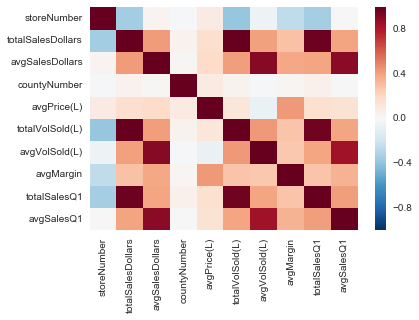

In [78]:
sns.heatmap(sales15.corr())

Right away, our correlation table and heat map show an incredibly strong positive relationship between 2015's first quarter sales and the year-end total of sales for stores, which is the relationship the state tax board wanted us to analyze.

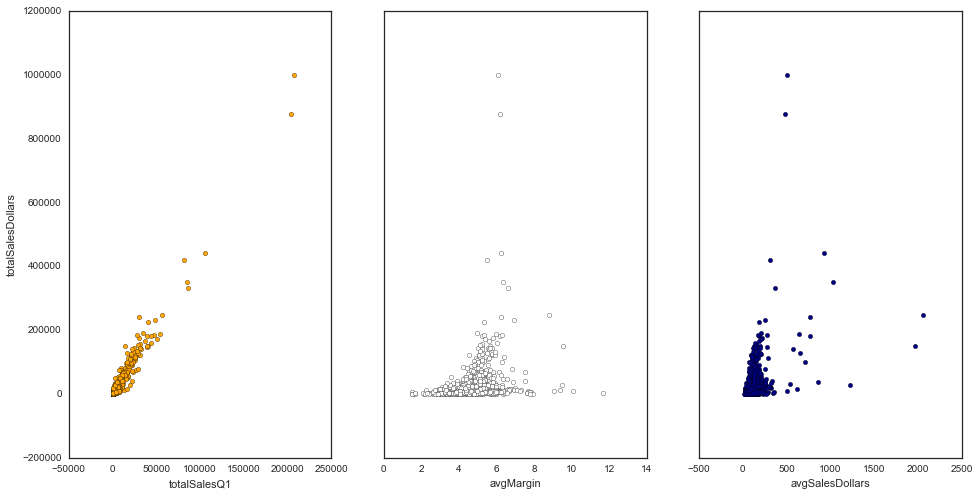

In [79]:
fig, axs = plt.subplots(1, 3, sharey=True) # ( _, _ )

sales15.plot(kind='scatter', x='totalSalesQ1', y='totalSalesDollars', ax=axs[0], figsize=(16, 8), color='orange')
sales15.plot(kind='scatter', x='avgMargin', y='totalSalesDollars', ax=axs[1], color='w')
sales15.plot(kind='scatter', x='avgSalesDollars', y='totalSalesDollars', ax=axs[2],color='navy')

We can compare the relationships between total sales for 2015 and several variables above. Clearly, as our correlation table above already informed us, first quarter sales have a strong relationship. 

Not so much for average margin. This makes sense, because a liquor store only has so much control over its average margin. A store could choose to increase its retail price over the bottle price, but its competitors will undercut them on the retail, and they'll have fewer sales. The market dictates the price for stores, so a store's average profit for a sale isn't going to increase or decrease the number of sales.

In [80]:
import statsmodels.formula.api as smf

model = smf.ols(formula="totalSalesDollars ~ totalSalesQ1", data=sales15)

fit = model.fit_regularized()

predictions = fit.predict(sales15[['totalSalesQ1']])

fit.summary()

#lm.summary()

#Prob (F-stat) is the p-value for the model as a whole?

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      totalSalesDollars   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 3.300e+04
Date:                Fri, 24 Jun 2016   Prob (F-statistic):               0.00
Time:                        16:36:27   Log-Likelihood:                -13418.
No. Observations:                1261   AIC:                         2.684e+04
Df Residuals:                    1259   BIC:                         2.685e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept      279.7219    309.252      0.905      0.366      -326.984   886.428
totalSalesQ1     4.4710      0.025    181.670      0.000         4.423     4.519
==============================================================================
Omnibus:                      608.483   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36456.060
Skew:                           1.420   Prob(JB):                         0.00
Kurtosis:                      29.188   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Many - including myself - assume that consumption habits would be cyclical, expecially in a state like Iowa, which is pretty cold between January and March. For example, overall spending tends to rise with the summer and holiday seasons, and dip in the fall and winter seasons, which means slow sales in the first quarter usually don't mean slow sales forever, as they'll probably pick up later in the year. 

Not the case with alcohol consumption.

Above we create a model that judges the impact first quarter sales will have in determining year-end totals for stores, then print a summary table of the model. 

Our R-squared value of 0.963 shows that over 96% of the variation in total sales for 2015 is explained by the variation in first quarter sales. The more a store sells in the first quarter, the more it will sell by the end of the year.

As we can see below, our high R-squared value translates to a regression line that fits our observed data - sales in 2015 - very well.

So for every dollar of Quarter 1 sales, we expect $4.47 added to our yearly total.

Our intercept starts at $279 because it's possible to make no sales at all in Quarter 1, yet still make money over the course of the year. This is the case because some stores aren't open in Quarter 1.

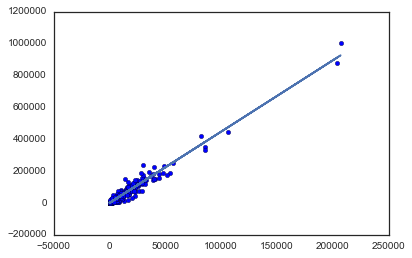

In [81]:
plt.scatter(sales15['totalSalesQ1'], sales15['totalSalesDollars'])
plt.plot(sales15['totalSalesQ1'],predictions)

Now we can apply our model created with our data from 2015, and substitute the current sales from 2016's first quarter. Our line now represents what expected total sales will be at the end of 2016. As we can see in the model below, our line extends slightly beyond the 2015 sales figures, meaning total sales across the state will increase this year.

We'll analyze this projection more closely later on.

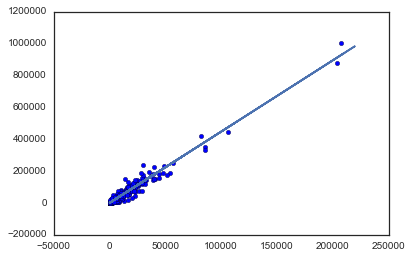

In [82]:
predictions16 = fit.predict(sales16[['totalSalesQ1']])


plt.scatter(sales15['totalSalesQ1'], sales15['totalSalesDollars'])
plt.plot(sales16['totalSalesQ1'],predictions16)

In order to truly assess our model's validity, we'll run it through a test-train split and cross validate the model below.

In [83]:
from sklearn import datasets, linear_model
from sklearn.cross_validation import train_test_split

#train_test_split was imported above with sklearn
#if you just imported sklearn, you'd have to call sklearn.cross_validation.train_test_split
#below specifies the orders of your data
X_train, X_test, y_train, y_test = train_test_split(sales15[['totalSalesQ1']], sales15[['totalSalesDollars']], test_size=0.3)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(882, 1) (882, 1)
(379, 1) (379, 1)


We split our data into a test-section of 2015's sales, which we'll run our model on. Then, we'll test our model on the remaining portion of 2015's sales that we didn't use. This will for our model to assume that the test-section is 'future' data. Rather than wait for 2016 sales to happen, we can just take this slice of 2015 to test the accuracy of our model.

As above, this gives us an R-squared score of .929, so slightly lower than the original run.

Score: 0.9730723397


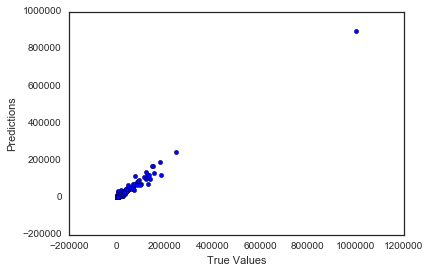

In [84]:
#you just substantiate a linear model into 'lm' so it's easier to call later
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", model.score(X_test, y_test)

In order to get the most accurate R-squared value, we can run a cross-validation below. This repeats the test-train split process above, except it slices the test-train sections in different spots of the frame each time. Then, it averages the R-squared values of each tes-train split.

Below, we do 6 different splits, and average their R-squared values, for a final result of .957, very close to our original above of .963, and upholding the fact that first quarter sales are a strong predictor of year-end sales.

Cross-validated scores: [ 0.94902406  0.92545466  0.80448348  0.86653769  0.98418855  0.82199832]
Cross-Predicted Accuracy: 0.957985969025


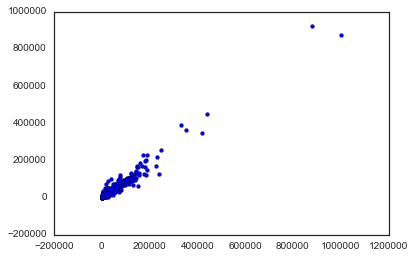

In [85]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 6-fold cross validation
projectedSales = cross_val_score(model, sales15[['totalSalesQ1']], sales15[['totalSalesDollars']],cv=6)
print "Cross-validated scores:", projectedSales
# Make cross validated predictions
predictions = cross_val_predict(model, sales15[['totalSalesQ1']], sales15[['totalSalesDollars']], cv=6)
plt.scatter(sales15[['totalSalesDollars']], predictions, s=15, c='b')
accuracy = metrics.r2_score(sales15[['totalSalesDollars']], predictions)
print "Cross-Predicted Accuracy:", accuracy

*Move the math above below the bar graph to provide the exact numbers. Then analyze and begi ndiscussion as to the state's posed problem*

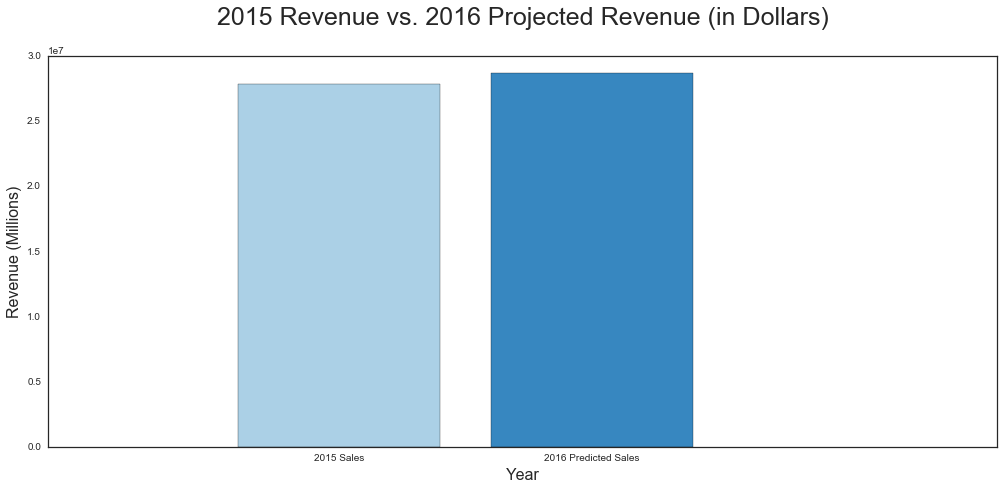

In [86]:
x=['2015 Sales','2016 Predicted Sales']
y=[27855892,28701742]
sns.set_context(rc={"figure.figsize": (17, 7)})
nd = np.arange(2)
width=0.8
plt.xticks(nd+width/2., ('2015 Sales','2016 Predicted Sales'))
plt.xlim(-0.75,3)
fig = plt.bar(nd, y, color=sns.color_palette("Blues",2))
plt.title('2015 Revenue vs. 2016 Projected Revenue (in Dollars)\n', fontsize=25)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Revenue (Millions)', fontsize=16)
plt.show()

Above, we have a simple representation of our linear model above that predicts 2016 year-end sales. The 2016 predicted push slightly beyond total sales from last year.

By printing the sums below, we see that 2016 year end sales are projected to be nearly $900,000 greater than 2015's total.

That isn't huge growth over time, which makes sense. Iowa's population isn't expanding, and the slight increase can be explained in the number of liquor stores that reported sales in 2016's first quarter versus 2015's first quarter. In the first quarter of 2015, 1261 liquor stores reported sales, while in 2016 that figure grew to 1280. 

More stores will ultimately mean more revenue generated overall.

In [87]:
print sales15['totalSalesDollars'].sum()
print predictions16.sum()
print predictions.sum()

27855892.42
28701742.0689
27269978.9772


In [88]:
print sales15.shape
print sales16.shape

(1261, 12)
(1280, 12)


While we can now predict with great certainty that more liquor will be sold by the end of this year, this isn't enough information to decide whether increasing or decreasing the liquor tax rate across the state will help with anything.

In order to get a clearer idea on a tax adjustment's impact, we can look at where liquor is being sold across the state.

In [89]:
df.sort_values(by=["City", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
salesPlay = df[mask]

# Group by store name
salesPlay = salesPlay.groupby(by=["County"], as_index=False)
# Compute sums, means
salesPlay = salesPlay.agg({"Sale (Dollars)": np.sum})

In [90]:
df1 = df.sort_values(by=["County", "Date"])
salesPlay.columns = ['County', 'sumOfSales15']
df1.dropna(inplace=True)
df1['totalSales'] = df1.groupby(['County'])['Sale (Dollars)'].transform('count')

salesPlay['totalSales15'] = df1['totalSales']

In [91]:
df1 = df1.loc[df1['County'].isin(['Polk','Linn', 'Scott', 'Johnson', 'Black Hawk', 'Pottawattami', 'Woodbury', 
                           'Dubuque', 'Story', 'Cerro Gordo'])]

By playing with the data, we can display liquor sold by county and city throughout the state.

Our first plot below is simply a count of transactions across the state. Polk county has more liquor sales than the other counties, which makes sense with Des Moines situated there.

In [92]:
salesPlay.to_csv('../assets/03-project3-assets/topTenCounties.csv')
sales15.to_csv('../assets/03-project3-assets/liquorSales15.csv')

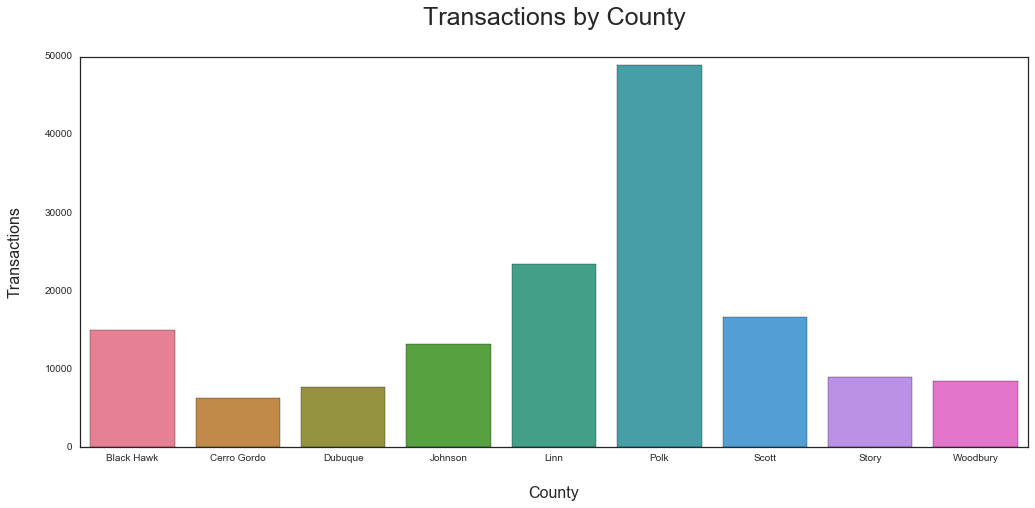

In [93]:
sns.countplot(x="County", data=df1, palette="husl")
plt.title('Transactions by County\n', fontsize=25)
plt.xlabel('\nCounty', fontsize=16)
plt.ylabel('Transactions\n', fontsize=16)

In [94]:
salesPlay.sort_values(by='sumOfSales15', ascending=0, inplace=True)
salesPlay.head(11)
salesPlay = salesPlay.drop(salesPlay[salesPlay.sumOfSales15 < 570061.54].index)
salesPlay

,County,sumOfSales15,totalSales15
76,Polk,6402210.51,1100
56,Linn,2606326.77,699
81,Scott,2044168.58,48944
51,Johnson,1719917.10,1133
6,Black Hawk,1583084.01,3522
77,Pottawattamie,1013367.23,3409
96,Woodbury,1000584.90,3975
30,Dubuque,888989.08,8944
84,Story,887234.71,298
16,Cerro Gordo,570061.54,15030


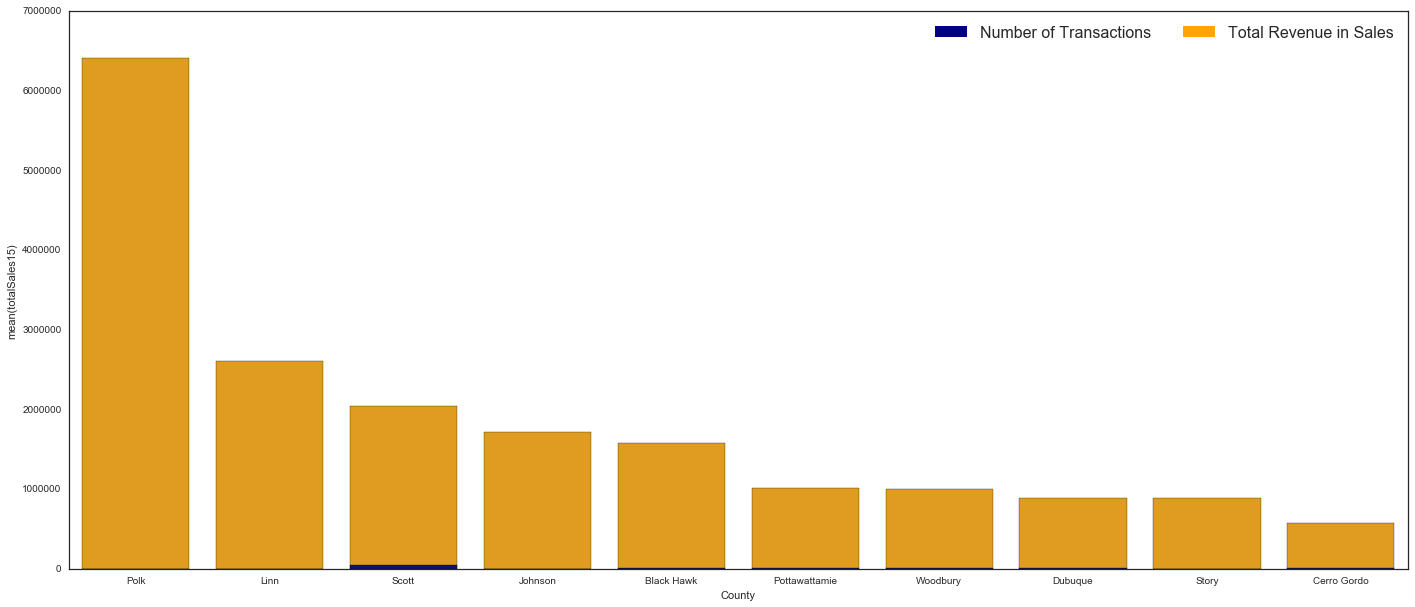

In [95]:
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = salesPlay['County'], y = salesPlay['sumOfSales15'], color = "orange")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = salesPlay['County'], y = salesPlay['totalSales15'], color = "navy")


topbar = plt.Rectangle((0,0),1,1,fc="orange", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='navy',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Number of Transactions', 'Total Revenue in Sales'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

This bar chart above  is a bit more informative.

Again, we see Polk county has the greatest revenues, by far. In fact, liquor stores in Polk county amassed three times the total revenue as stores in Scott County. However, it's interesting to note, by way of the table above and the navy bar stacked on top of the orange, that stores in Scott County had almost five times as many transactions.This must mean that stores in Polk are generating revenue off bulk or wholesale transactions, making many stores probable distributors to bars and restaurants. 

With so much revenue coming by way of bulk purchases, an increase in the state's liquor tax may hurt distributors like those located in Polk County. Individual customers looking to purchase a single bottle of wine or tequila may not be bothered, but a large enough tax hike could force bulk purchasers to take their business elsewhere, like across the border to Missouri, where they may enjoy a more favorable tax on the purchases.

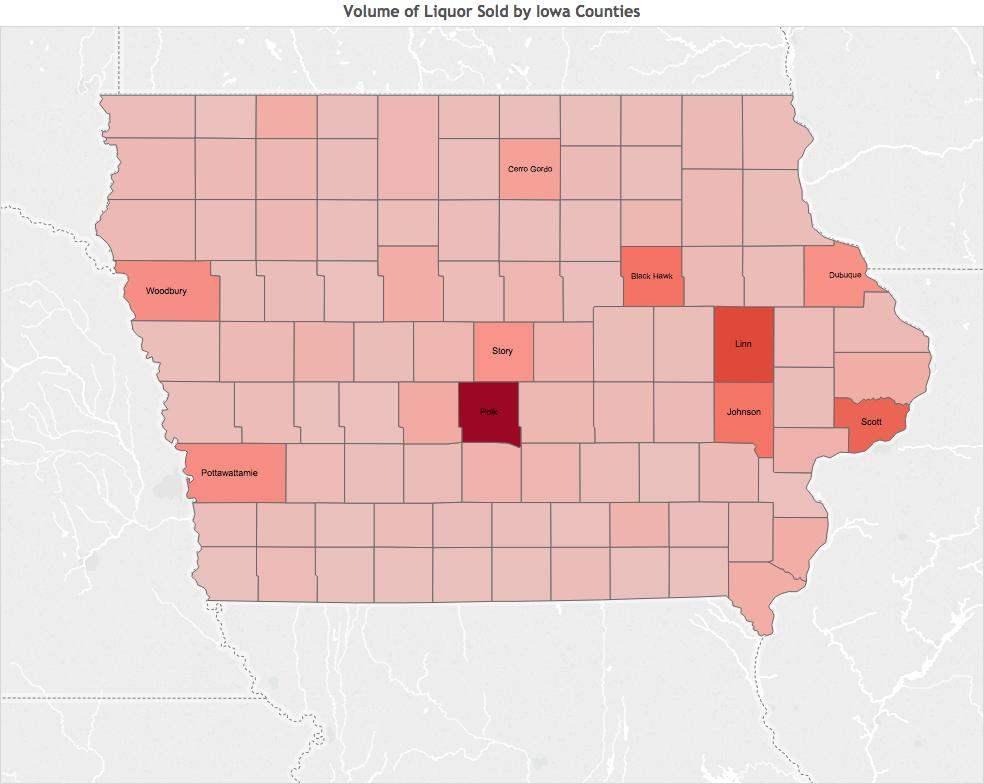

In [96]:
Image(filename='../assets/03-project3-assets/visuals_IowaLiquorSales/volumeOfLiquorSoldByCounty.jpg')

A tax increase across the state would possibly hurt many liquor stores along the borders. In the map below, we see total sales from 2015 for some of Iowa's cities, many of which lie on top of a border with another state, where a drive across state lines doesn't take very long. Customers could simply make their purchases in a neighboring state

While a tax increase may help spur growth of competitors across state lines, the inverse of that may also be true. A decrease in the rate may be an incentive for customers in South Doakot and Wisconsin to make purchases in Sioux City and Dubuque, respectively.

Likewise, a more relaxed liquor tax may also spur development in Des Moines, the state capital, and Iowa City, home of the University of Iowa. In the past year, each city's population has grown by more than 7%, nearly 4 times the state's languid growth rate of 2% since 2010, one of the slowest growth rates in the US. 

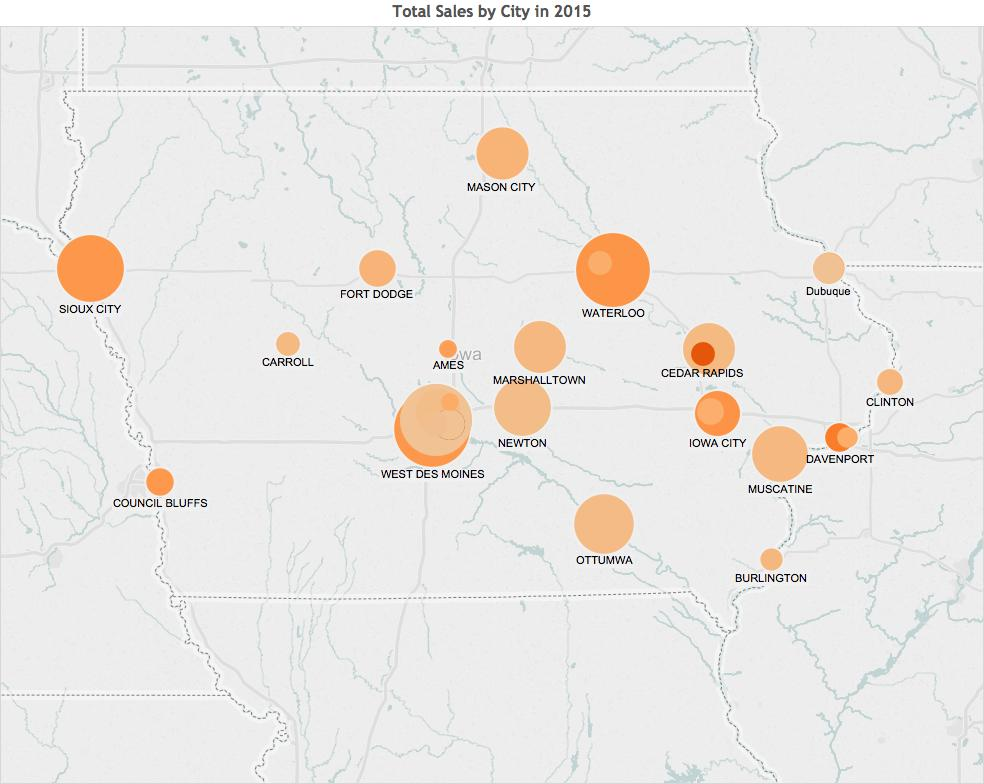

In [97]:
Image(filename='../assets/03-project3-assets/visuals_IowaLiquorSales/totalIowaLiquorSalesByCity2015HeatMap.jpg')

Making a definitive decision in regards to adjusting the liquor tax rate up or down requires a bit more information. Something that would assist are historical studies of similar situations in other states over time, as well as projected tax revenues from different hypothetical rates. However, we would ultimately need to determine the tax rate at which consumption would decrease as a result of higher price.

I'd recommend a more localized solution, where cities like Des Moines or Iowa City may benefit from a decrease in tax rates as a way to spur business development that will meet growing demand as their populations continue to expand. This localized solution makes more sense over a general tax fluctuation across the state because the rising populations for these cities are not a result of people moving to Iowa from other states, but simply relocating within the state. This means a lower tax rate for all cities won't have a similar effect of business develpment, since their number of potential consumers is likely stagnant, or moving to Des Moines or Iowa City.

This localized approach may also be the better option for border cities as well. As stated above, a higher rate may hurt border cities by having their customers pruchase alcohol across state lines. It may also help them generate revenues by giving more favorable rates to customers in other states. However, most border cities in Iowa have largely empty land across the border from them, so this scenario wouldn't apply to most. Council Bluffs, on the other hand, is a five minute drive from Omaha, Nebraska, that state's largest city by poplation, meaning many potential customers if Council Bluffs can offer a lower tax rate on alcohol purchases, especially for bars and restaurants that are hoping to make wholesale purchases.

# Summary:

* First quarter sales are a reliable predictor of yearly total sales when it comes to liquor consumption in Iowa.
* Based on the Quarter 1 sales so far in 2016, we can reliably predict that sales for 2016 will be slightly greater than the total sales in 2015.
* Adjustments in liquor tax rates should be based on the paritcular circumstances of cities and counties, based on projected population shifts and proximity to markets in other states.